# Baselines

S. https://nbviewer.org/github/pycaret/pycaret/blob/master/tutorials/Tutorial%20-%20Regression.ipynb

## Setup
---

In [1]:
# helper functions
from FLutils import (
    load_df,               # load data
    #create_keras_model,    # construct a deep neural network (keras)
    #model_fn,              # convert keras model to tff.learning.models
    #prep_fed_train,        # convert training data to tensors for learning with tensorflow
    #prep_fed_test,         # convert test data to tensors for testing with tensorflow (other format than training data)
    #train_model,           # train a keras model
    #train_fed              # train a keras model federated with distributed data
    )


2023-06-22 11:24:38.561838: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 11:24:39.781810: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# ingest data
# ===========

df_paths = [
    '../output/data/insurance-clean.csv',
    "https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv"
]

df = load_df(df_paths)
df.head(3)

loaded data from ../output/data/insurance-clean.csv


,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.9240,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.5523,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.4620,0.0,0.0,1.0,0.0


In [3]:
from pycaret.datasets import get_data
df = get_data('insurance')

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# select features, target (first column) and clients
# ==================================================

# features for centralized learning
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3']

target = 'charges'

# features for federated learning
features_fed = features[:5]

# clients for data splits
clients = df.region.unique()
# ----------------------------------
#show target + features in the data
#df_ml = df.loc[:, [target] + features]
#df_ml.head(3)


In [5]:
# imports
# =======
# ======
from pycaret import *
from pycaret.regression import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor



## Pycaret
---

See https://github.com/pycaret/pycaret/blob/master/tutorials/Tutorial%20-%20Regression.ipynb

- `compare_models`
  - gbr has with 0.8320 best $\mathrm{R}^2$
  - dt has default 0.6476 and tuned 0.8265, custom grid 0.8369, optuna optimizer 0.8235
  - dt bagging  0.8117
  - dt boosting 0.7838
  - blending top 3 models: 0.8289
  - stacking top 3 models: 0.8336

In [6]:
# Setup
clf = setup(
    df, target = target
    , session_id = 42#, preprocess=False
    , log_experiment = True
    , imputation_type = None
    , encoding_method = 'onehot'
    , normalize = True, normalize_method = 'minmax'
    , fold_strategy = 'kfold', fold = 5
)
#get_config('seed')
get_config('dataset_transformed').head()

,Description,Value
0,Session id,42
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1338, 7)"
4,Transformed data shape,"(1338, 10)"
5,Transformed train set shape,"(936, 10)"
6,Transformed test set shape,"(402, 10)"
7,Ordinal features,2
8,Numeric features,3
9,Categorical features,3


,age,sex,bmi,children,smoker,region_northwest,region_southwest,region_southeast,region_northeast,charges
332,0.934783,0.0,0.408932,0.0,0.0,1.0,0.0,0.0,0.0,13429.035156
355,0.608696,1.0,0.313156,0.0,0.0,0.0,1.0,0.0,0.0,24603.048828
138,0.782609,0.0,0.428840,0.6,0.0,0.0,0.0,1.0,0.0,27322.734375
381,0.804348,1.0,0.396153,0.0,1.0,0.0,0.0,0.0,1.0,42303.691406
292,0.152174,1.0,0.795803,0.4,1.0,0.0,0.0,1.0,0.0,42112.234375


In [7]:
# benchmark experiment (default parameter)
best = compare_models(
    sort = "R2"
    , fold = 5
    , n_select = 10
    , include = ['gbr', 'catboost', 'rf', 'ada', 'et', 'xgboost', 'lr', 'knn', 'dt', 'dummy']
    #, budget_time = 5
)

# logging application
#!mlflow ui

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:24:49
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2741.5717,23279192.8133,4812.9985,0.8352,0.4479,0.3189,0.4860
catboost,CatBoost Regressor,2908.3170,24747331.4960,4968.7234,0.8258,0.4875,0.3358,0.5220
rf,Random Forest Regressor,2939.7846,26178160.0952,5113.7800,0.8160,0.4717,0.3342,0.4720
et,Extra Trees Regressor,2930.3418,28971690.8933,5376.8658,0.7958,0.4830,0.3236,0.1540
xgboost,Extreme Gradient Boosting,3241.1538,29502237.2000,5428.6495,0.7928,0.5540,0.3845,0.1200
ada,AdaBoost Regressor,4364.8351,29592120.3805,5427.0955,0.7907,0.6233,0.7136,0.2200
lr,Linear Regression,4298.2148,38600130.7875,6207.8966,0.7275,0.5854,0.4331,0.1160
knn,K Neighbors Regressor,3913.7231,39909952.8000,6312.7642,0.7196,0.4916,0.3629,0.1160
dt,Decision Tree Regressor,3632.1261,51820427.0174,7186.7137,0.6405,0.5463,0.3915,0.1160
dummy,Dummy Regressor,9120.9467,146731281.6000,12083.1605,-0.0047,1.0002,1.5298,0.1120


Processing:   0%|          | 0/54 [00:00<?, ?it/s]

In [8]:
best_tuned = []
best_scores = []
for model in best[:9]:
    print("----------------------------------------------------------------")
    tuned_model = tune_model(model, n_iter = 100)
    best_tuned.append(tuned_model)
    best_scores.append(pull())
    print(tuned_model)

----------------------------------------------------------------


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2585.8896,20483885.9991,4525.9127,0.8675,0.4202,0.3076
1,2614.2312,18742963.9708,4329.3145,0.8929,0.4413,0.3168
2,2784.8443,24016204.6885,4900.6331,0.7936,0.4287,0.2706
3,2819.0039,25195743.7328,5019.5362,0.8111,0.4744,0.3111
4,2832.1594,24201476.7631,4919.4996,0.8393,0.4820,0.3214
Mean,2727.2257,22528055.0309,4738.9792,0.8409,0.4493,0.3055
Std,105.3545,2475359.9363,264.8223,0.0362,0.0246,0.0181


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits
GradientBoostingRegressor(learning_rate=0.15, max_depth=2, max_features=1.0,
                          min_impurity_decrease=0.005, min_samples_leaf=3,
                          min_samples_split=5, n_estimators=150,
                          random_state=42, subsample=0.9)
----------------------------------------------------------------


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2566.7842,19712126.5205,4439.8341,0.8725,0.4236,0.3243
1,2497.0042,18163272.4496,4261.8391,0.8962,0.3888,0.2810
2,2714.5628,24207429.9692,4920.1047,0.7919,0.4281,0.2762
3,2699.2743,24124605.9706,4911.6806,0.8191,0.4272,0.2950
4,2771.4157,23264894.6384,4823.3696,0.8456,0.4574,0.3357
Mean,2649.8083,21894465.9096,4671.3656,0.8450,0.4250,0.3024
Std,101.6568,2485389.7955,269.8320,0.0371,0.0218,0.0236


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits
----------------------------------------------------------------


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2607.8621,20142693.5630,4488.0612,0.8697,0.4305,0.3317
1,2341.4224,16813178.3301,4100.3876,0.9039,0.3905,0.2835
2,2809.0234,24806699.8194,4980.6325,0.7868,0.4267,0.2913
3,2760.5979,23141521.2737,4810.5635,0.8265,0.4459,0.3191
4,2868.9452,24124237.3682,4911.6430,0.8399,0.4437,0.3360
Mean,2677.5702,21805666.0709,4658.2576,0.8453,0.4275,0.3123
Std,189.0251,2961651.4632,326.0407,0.0396,0.0199,0.0212


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits
RandomForestRegressor(max_depth=4, min_impurity_decrease=0.001,
                      min_samples_leaf=6, n_estimators=60, n_jobs=-1,
                      random_state=42)
----------------------------------------------------------------


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2617.6429,20733926.4583,4553.4521,0.8658,0.4143,0.3058
1,2624.3274,19382591.2795,4402.5664,0.8892,0.4073,0.2993
2,2850.8760,25799475.8779,5079.3184,0.7782,0.4352,0.2887
3,2749.1218,25314540.3294,5031.3557,0.8102,0.4346,0.2924
4,2777.9423,22994665.1839,4795.2753,0.8474,0.4520,0.3246
Mean,2723.9821,22845039.8258,4772.3936,0.8382,0.4287,0.3022
Std,90.4266,2501793.8547,263.2471,0.0396,0.0161,0.0127


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits
ExtraTreesRegressor(max_depth=7, min_impurity_decrease=0.2, min_samples_leaf=2,
                    n_estimators=280, n_jobs=-1, random_state=42)
----------------------------------------------------------------


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2562.4468,19918714.0000,4463.0386,0.8711,0.4182,0.3127
1,2432.6992,17538358.0000,4187.8823,0.8998,0.4039,0.2914
2,2798.9631,24593978.0000,4959.2314,0.7886,0.4209,0.2714
3,2817.0659,24844824.0000,4984.4580,0.8137,0.4514,0.3135
4,2834.3240,23794490.0000,4877.9595,0.8420,0.4625,0.3331
Mean,2689.0998,22138072.8000,4694.5140,0.8430,0.4314,0.3044
Std,162.0602,2904638.3622,315.6110,0.0396,0.0219,0.0211


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits
XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=130, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)
----------------------------------------------------------------


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2801.2704,21688144.5131,4657.0532,0.8597,0.4571,0.3663
1,2506.2880,18207126.1562,4266.9809,0.8960,0.4041,0.3036
2,2846.3274,25104029.6598,5010.3922,0.7842,0.4519,0.3176
3,2935.6966,23839062.4066,4882.5262,0.8212,0.4823,0.3542
4,3095.6751,26495211.8598,5147.3500,0.8241,0.4881,0.4054
Mean,2837.0515,23066714.9191,4792.8605,0.8370,0.4567,0.3494
Std,193.5912,2898890.2213,308.5501,0.0379,0.0298,0.0362


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits
AdaBoostRegressor(learning_rate=0.0005, loss='exponential', n_estimators=110,
                  random_state=42)
----------------------------------------------------------------


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4323.0640,36663918.2208,6055.0738,0.7628,0.5342,0.4763
1,4309.1244,34914041.1432,5908.8105,0.8005,0.5312,0.4275
2,4545.3032,42846069.4537,6545.6909,0.6317,0.7189,0.4522
3,4345.4000,41870719.8761,6470.7588,0.6860,0.6093,0.4042
4,3978.0255,36444362.9203,6036.9167,0.7581,0.7295,0.4105
Mean,4300.1834,38547822.3228,6203.4501,0.7278,0.6246,0.4341
Std,182.4924,3184166.4006,255.0075,0.0607,0.0861,0.0268


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 2 candidates, totalling 10 fits
LinearRegression(fit_intercept=False, n_jobs=-1)
----------------------------------------------------------------


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3452.2969,31710226.3208,5631.1834,0.7948,0.4530,0.3387
1,3449.3132,33301756.7033,5770.7674,0.8097,0.4638,0.3177
2,3951.2652,40081995.6850,6331.0343,0.6555,0.4655,0.3370
3,3539.4003,37203206.7015,6099.4431,0.7210,0.4552,0.3203
4,3703.6679,39330657.7668,6271.4159,0.7389,0.5006,0.3460
Mean,3619.1887,36325568.6355,6020.7688,0.7440,0.4676,0.3320
Std,189.9938,3297161.7104,275.5198,0.0553,0.0172,0.0110


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits
KNeighborsRegressor(metric='manhattan', n_jobs=-1, n_neighbors=7,
                    weights='distance')
----------------------------------------------------------------


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1839.3663,20283307.6733,4503.6993,0.8688,0.3569,0.1359
1,1709.8257,17210098.8911,4148.5056,0.9017,0.3478,0.1223
2,2167.1858,25878724.5680,5087.1136,0.7776,0.4267,0.1439
3,2039.0574,24127289.1321,4911.9537,0.8191,0.3962,0.1375
4,2085.2789,24451652.9232,4944.8613,0.8377,0.4223,0.1524
Mean,1968.1428,22390214.6375,4719.2267,0.8409,0.3900,0.1384
Std,168.3324,3184629.1226,345.1290,0.0423,0.0326,0.0099


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits
DecisionTreeRegressor(criterion='absolute_error', max_depth=6, max_features=1.0,
                      min_impurity_decrease=0.1, min_samples_leaf=6,
                      min_samples_split=7, random_state=42)
----------------------------------------------------------------


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:42:58
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Dummy Regressor


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

ValueError: parameter grid for tuning is empty. If passing custom_grid, make sure that it is not empty. If not passing custom_grid, the passed estimator does not have a built-in tuning grid.

In [10]:
res = []

for i in range(len(best_scores)):

    sc = best_scores[i]
    sc['model'] = [type(best_tuned[i]).__name__] * len(sc)
    sc['tuned_params'] = [best_tuned[i].get_params()] * len(sc)
    res.append(sc)

res = pd.concat(res)

res_mean = res[res.index.isin(['Mean'])].reset_index(drop = True)
res_mod = res_mean[['model', 'tuned_params']]
res_mean = res_mean.loc[:,~res_mean.columns.isin(['model', 'tuned_params'])]
res_mean.columns = [x + '_mean' for x in res_mean.columns]

res_std = res[res.index.isin(['Std'])].reset_index(drop = True)
res_std = res_std.loc[:,~res_std.columns.isin(['model', 'tuned_params'])]
res_std.columns = [x + '_std' for x in res_std.columns]


res2 = pd.concat([res_mean, res_std, res_mod], axis = 1)
res2[sorted(res2.columns)].sort_values('R2_mean', ascending=False)


,MAE_mean,MAE_std,MAPE_mean,MAPE_std,MSE_mean,MSE_std,R2_mean,R2_std,RMSE_mean,RMSE_std,RMSLE_mean,RMSLE_std,model,tuned_params
2,2677.5702,189.0251,0.3123,0.0212,2.180567e+07,2.961651e+06,0.8453,0.0396,4658.2576,326.0407,0.4275,0.0199,RandomForestRegressor,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
1,2649.8083,101.6568,0.3024,0.0236,2.189447e+07,2.485390e+06,0.8450,0.0371,4671.3656,269.8320,0.4250,0.0218,CatBoostRegressor,"{'depth': 4, 'l2_leaf_reg': 10, 'loss_function..."
4,2689.0998,162.0602,0.3044,0.0211,2.213807e+07,2.904638e+06,0.8430,0.0396,4694.5140,315.6110,0.4314,0.0219,XGBRegressor,"{'objective': 'reg:squarederror', 'base_score'..."
0,2727.2257,105.3545,0.3055,0.0181,2.252806e+07,2.475360e+06,0.8409,0.0362,4738.9792,264.8223,0.4493,0.0246,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ..."
8,1968.1428,168.3324,0.1384,0.0099,2.239021e+07,3.184629e+06,0.8409,0.0423,4719.2267,345.1290,0.3900,0.0326,DecisionTreeRegressor,"{'ccp_alpha': 0.0, 'criterion': 'absolute_erro..."
3,2723.9821,90.4266,0.3022,0.0127,2.284504e+07,2.501794e+06,0.8382,0.0396,4772.3936,263.2471,0.4287,0.0161,ExtraTreesRegressor,"{'bootstrap': False, 'ccp_alpha': 0.0, 'criter..."
5,2837.0515,193.5912,0.3494,0.0362,2.306671e+07,2.898890e+06,0.8370,0.0379,4792.8605,308.5501,0.4567,0.0298,AdaBoostRegressor,"{'base_estimator': 'deprecated', 'estimator': ..."
7,3619.1887,189.9938,0.3320,0.0110,3.632557e+07,3.297162e+06,0.7440,0.0553,6020.7688,275.5198,0.4676,0.0172,KNeighborsRegressor,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
6,4300.1834,182.4924,0.4341,0.0268,3.854782e+07,3.184166e+06,0.7278,0.0607,6203.4501,255.0075,0.6246,0.0861,LinearRegression,"{'copy_X': True, 'fit_intercept': False, 'n_jo..."


In [17]:
np.sqrt(res2[sorted(res2.columns)].sort_values('R2_mean', ascending=False).head(1).MSE_std)


2    0.36859
Name: MSE_std, dtype: float64

## Investigate results
---

In [58]:
#evaluate_model(best_tuned[2])

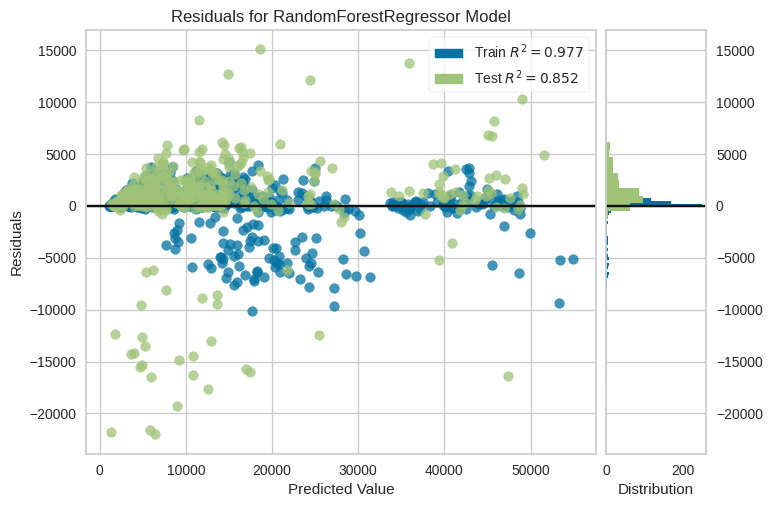

In [59]:
plot_model(best_tuned[2])

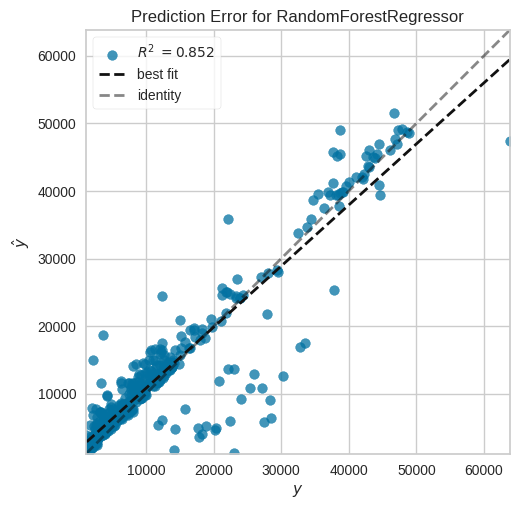

In [60]:
plot_model(best_tuned[2], plot = 'error')

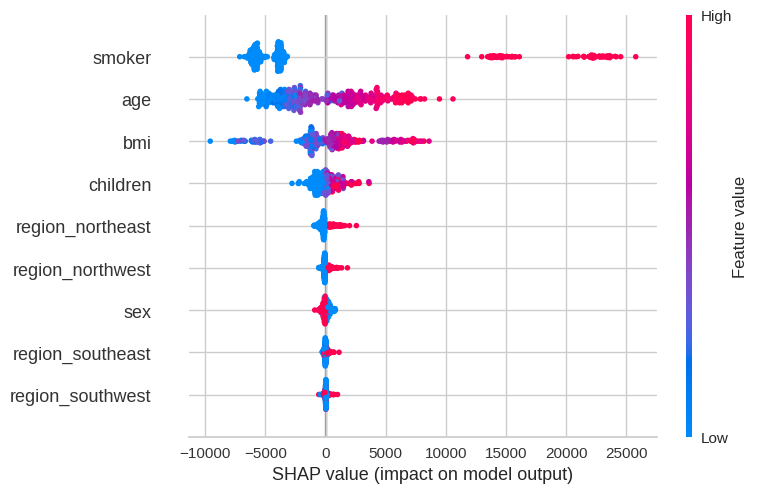

In [61]:
interpret_model(best_tuned[2], plot = 'summary')

In [63]:
interpret_model(best_tuned[2], plot = 'reason', observation = 1)

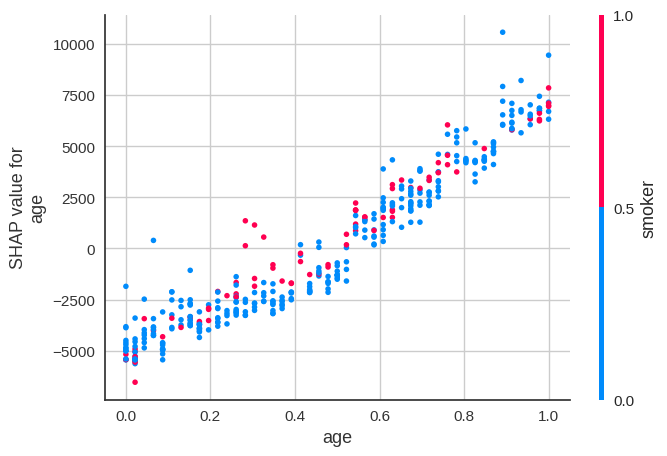

In [65]:
interpret_model(best_tuned[2], plot = 'correlation', observation = 1)

## Manual Tuning
---

See https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html

In [148]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

# Do the hyperparameter tuning for the Random Forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [3,4,5,6]
max_features = [0.5,0.6,0.7,0.8,0.9,0.95,1.0]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
clf = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = KFold(n_splits = 5, shuffle = True, random_state = 42), verbose=2, random_state=42, n_jobs = -1)# Fit the random search model

In [149]:
nested_score = cross_val_score(
    clf, X = df[features], y= df[target], 
    cv = KFold(n_splits = 4, shuffle = True, random_state = 42), scoring = 'r2'
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[CV] END bootstrap=True, max_depth=4, max_features=0.7, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=4, max_features=0.7, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=4, max_features=0.7, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=4, max_features=0.7, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=4, max_features=0.7, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=3, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.8s
[CV] END bootstrap=False, max_depth=3, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   1.8s
[CV] END bootstrap=False, max_depth=4, max_features=1.0

In [195]:
print('---- Result of nested resampling ----')
print("mean score = {:.6f} +- {:.6f} (std)".format(nested_score.mean(), nested_score.std()))
# See https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
# -> valid

--- Result of nested resampling ---
mean score = 0.856781 +- 0.024928 (std)


In [151]:
# tuning + training
clf.fit(df[features], df[target])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[CV] END bootstrap=True, max_depth=4, max_features=0.7, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=4, max_features=0.7, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=4, max_features=0.7, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=4, max_features=0.7, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=4, max_features=0.7, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END bootstrap=False, max_depth=3, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   2.2s
[CV] END bootstrap=False, max_depth=3, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   2.2s
[CV] END bootstrap=False, max_depth=3, max_features=1.0

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='squared_error',
                                                   max_depth=None,
                                                   max_features=1.0,
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=10...
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 4, 5, 6],
                                        'max_features': [0.5, 0.6, 0.7, 0.8,
                                                         0.9, 0.95, 1.0],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [201]:
result = pd.concat([pd.DataFrame({
    'rank_test_score': clf.cv_results_['rank_test_score'],
    'mean_test_score': clf.cv_results_['mean_test_score'],
    'std_test_score': clf.cv_results_['std_test_score']
}), pd.DataFrame(clf.cv_results_["params"])], axis = 1
          ).sort_values('rank_test_score').iloc[:,1:]
result

,mean_test_score,std_test_score,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,bootstrap
9,0.855824,0.033168,1200,2,4,0.90,5,True
0,0.854083,0.032916,200,10,2,0.70,4,True
14,0.854016,0.032615,1200,10,2,0.60,6,False
16,0.853733,0.034144,1600,2,4,0.80,5,False
11,0.853634,0.033663,400,10,2,0.95,6,True
13,0.853484,0.031801,1000,5,1,1.00,4,True
15,0.851834,0.031675,1200,10,2,0.70,4,False
4,0.851646,0.032332,1400,5,1,0.50,6,False
12,0.850790,0.031747,800,2,1,1.00,6,True
5,0.850716,0.032484,1000,10,1,0.80,4,False


In [208]:
print('RF - best hyperparameter and their cv score')
result.head(1).T

RF - best hyperparameter and their cv score


,9
mean_test_score,0.855824
std_test_score,0.033168
n_estimators,1200
min_samples_split,2
min_samples_leaf,4
max_features,0.9
max_depth,5
bootstrap,True
